# <h1 style="color:#2E86C1; text-align:center; font-size:2.8em; font-family: 'Segoe UI', Verdana, Geneva, Tahoma, sans-serif; letter-spacing:2px; margin-top:40px;">
#   PRUEBA TÉCNICA PARA CAMBRIAN INTELLIGENCE
# </h1>
# <h3 style="color:#117864; text-align:center; font-size:1.5em; font-family: 'Segoe UI', Verdana, Geneva, Tahoma, sans-serif; margin-bottom:40px;">
#   Autor: Alberto López Casanova
# </h3>

EDA



En primer lugar, vamos a realizar un analisis exploratorio de datos para entender el tipo de frases que tenemos y sacar estadisticas que puedan ser de valor

In [5]:
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import string
import re


1. CARGA Y VISUALIZACIÓN INICIAL

En primer lugar cargamos el archivo, que está en formato JSON.

In [2]:
with open('sentences.json', 'r') as f:
    sentences = json.load(f)

Hacemos un análisis básico para entender el dataset que tenemos

In [3]:
print(f"Total de frases: {len(sentences)}")

Total de frases: 100


In [4]:
print("Primeras 5 frases:")
for p in sentences[:5]:
    print("-", p)

Primeras 5 frases:
- The dragonfly's wings sparkled like gemstones in the sunlight.
- The bagpipes were adorned with a tartan pattern, honoring Scottish tradition.
- The fur pattern on the tiger was striking and intimidating.
- The triangle was simple but required precise timing.
- The sequoia tree was so tall it seemed to touch the sky.


In [6]:
print("Frases aleatorias del dataset:")
for p in random.sample(sentences, 5):
    print("-", p)

Frases aleatorias del dataset:
- The robot was capable of autonomous movement, revolutionizing industries.
- The grand piano filled the room, both in size and in sound.
- The maracas were hand-painted, each telling a unique story.
- The canoe was crafted from a single tree, showcasing traditional craftsmanship.
- The graffiti was a bright splash of color against the gray concrete wall.


Antes de entrar en análisis más profundo en cuanto a estadísticas y patrones de lenguaje en las diferentes frases, a simple vista podemos observar como tienen un patrón que se repite: Siempre empiezan con "The" + sustantivo para después describir una característica de este. Además, hacen uso de estructuras típicas de descripciones como analogías o comparaciones.

2. ANÁLISIS BÁSICO

En primer lugar analizamos metricas básicas como pueden ser longitudes de las frases, número de caracteres  y estadísticas. Para ello vamos a crear un DataFrame el cual contenga las frases, junto con el número de palabras y caracteres que tienen cada una.

In [10]:
df = pd.DataFrame({
    "phrase": sentences,
    "words": [len(p.split()) for p in sentences],
    "num_chars": [len(p) for p in sentences],
})

df.head()

,phrase,words,num_chars
0,The dragonfly's wings sparkled like gemstones ...,9,62
1,The bagpipes were adorned with a tartan patter...,11,77
2,The fur pattern on the tiger was striking and ...,10,59
3,The triangle was simple but required precise t...,8,52
4,The sequoia tree was so tall it seemed to touc...,12,56


A continuación obtenemos los estadísticos básicos de las columnas/características "words" y "num_chars"

In [13]:
df.describe()

,words,num_chars
count,100.000000,100.000000
mean,11.490000,68.110000
std,2.012562,8.874996
min,8.000000,52.000000
25%,10.000000,62.000000
50%,11.000000,66.000000
75%,13.000000,74.250000
max,18.000000,90.000000


En general se puede observar que al ser la media de palabras por frase de 11.49 y la desviación estándar 2.02, se puede afirmar que la longitud de las frases en cuanto a palabras es muy parecida. 
En lo que a numero de caracteres respecta, la desviación estándar es mayor pero es normal ya que puede haber palabras mas largas que otras.

In [15]:
# Configuración de estilo para gráficos

sns.set_theme(style="whitegrid")

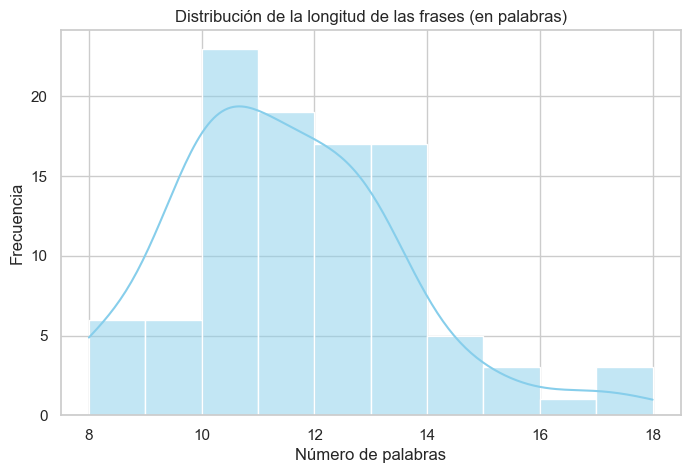

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(df["words"], bins=10, kde=True, color="skyblue")
plt.title("Distribución de la longitud de las frases (en palabras)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

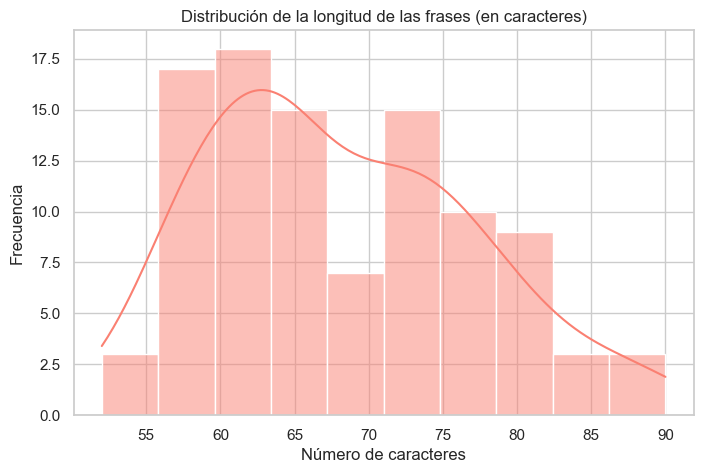

In [17]:
# Histograma de número de caracteres por frase
plt.figure(figsize=(8, 5))
sns.histplot(df["num_chars"], bins=10, kde=True, color="salmon")
plt.title("Distribución de la longitud de las frases (en caracteres)")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()

Gráficamente podemos observar como la mayoría de las frases tienen entre 10 y 13 palabras, por tanto las frases son descriptivas pero no cortas ni largas. La distribución de probabilidad tanto para palabras como caracteres se acerca a una distribución normal o campana de Gauss. A simple vista ya podíamos ver como se tratan de frases escritas a conciecia o seleccionadas con un criterio consistente ya que son frases descriptivas con mucha semántica incluida. Tras este análisis hemos podido ver que el rango de longitud es estrecho y la distrubución tiene una forma de campana de gauss estrecha por lo que se confirma lo que vemos a simple vista: frases parecidas en cuanto a longitud. En caso de tener una distribución asimétrica o mucha variacion en el numero de palabras, sabríamos que las frases serían texto sin curar, diálogos, etc... pero no es el caso.

CONCLUSIONES: La mayoría de las frases tienen entre 10 y 13 palabras, con una moda cercana a las 11. Esto sugiere un estilo de escritura controlado y descriptivo, con frases suficientemente largas como para contener ideas completas, pero no tan extensas como para perder coherencia semántica. Esta longitud es ideal para tareas de representación semántica mediante el uso de embeddings.

3. ANALISIS LEXICO Y LINGUISTICO CON SPACY

In [18]:
nlp = spacy.load("en_core_web_sm")

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.